# Model Creation

After cleaning and getting a preliminary idea of the data, we're going to fit several models and evaluate them using the Mean Absolute Error (MAE). The models I'm going to try are:

* Linear Regression
* Ridge Regression
* Lasso Regression
* RandomForestRegressor

For the metrics, I am using the R^2 value to evaluate how well the closely our model fits to the data, and I'm also using the mean absolute error to tell a more concrete story of how well our model is performing. 

Instead of mean squared error, I used mean absolute error because we have several large outliers and I don't want our metric to be skewed by the large errors that'd be generated when we try to predict them using a model meant for typical revenue. It's also more interpretable, with the error returned simple being how many dollars, on average, we're off from the actual weekly revenue.

In [2]:
#Importing necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.model_selection import GridSearchCV

## Finding the best features.

First, I'm going to see whether the logged values or the exponential values perform best for each model. After finding that, I would then find the most important features for that particular model.

In [3]:
#Reading in the original test data
df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\train_all_features.csv', index_col=0)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,...,log_revenue,Total_MarkDown,Year,Month,Week_of_year,Day,Median_Sales,IsThanksgiving,IsChristmas,IsDept72
0,26,92,87235.57,False,61.10,3.796,136.213613,7.767,152513,1,...,11.431992,0.0,2011,8,34,26,80340.795,False,False,False
1,26,92,80254.53,False,50.72,3.758,136.367000,7.767,152513,1,...,11.353279,0.0,2011,9,38,23,80340.795,False,False,False
2,26,92,77715.58,False,56.74,4.034,134.767774,7.818,152513,1,...,11.323042,0.0,2011,5,21,27,80340.795,False,False,False
3,26,92,83599.56,False,59.89,3.815,135.446800,7.767,152513,1,...,11.391769,0.0,2011,7,26,1,80340.795,False,False,False
4,26,92,77876.10,False,33.81,3.919,134.357100,7.818,152513,1,...,11.324981,0.0,2011,4,16,22,80340.795,False,False,False


### Determining whether to use logged or unlogged values

In [3]:
linear = LinearRegression()
rf = RandomForestRegressor()

#Creating Features and Target
X = df.drop(['Weekly_Sales','log_revenue'], axis=1).values
y_log = df['log_revenue'].values
y_not = df['Weekly_Sales'].values

#Function for creating training and testing dataset
def mean_abs_error(y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if (y == y_log).all():
        y_pred = np.exp(y_pred) - 4989.94
        y_true = np.exp(y_test)
    else:
        y_true = y_test
    return mean_absolute_error(y_true, y_pred)

In [4]:
#Linear
print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,linear),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,linear),2)))

The mean absolute error calculated using the logged values is 15815.77
The mean absolute error calculated using the original values is 2585.23


In [5]:
#RandomForestRegressor
print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,rf),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,rf),2)))

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The mean absolute error calculated using the logged values is 5454.67
The mean absolute error calculated using the original values is 1825.17


In both cases, it appears that we should use the original values.

### RFE feature selector for Linear Regression model

In [6]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_not, test_size=0.3)

In [8]:
def feature_selector(model):
    #Optimal number of features
    number_of_features = len(df.drop(['Weekly_Sales','log_revenue'], axis=1).columns)
    options_for_features = np.arange(1,number_of_features)
    low_score = 4000 #A number we're certainly going to be lower than
    nof = 0
    #Fitting model
    for n in range(len(options_for_features)):
        #Creating model
        rfe = RFE(model,options_for_features[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        #Fitting model
        model.fit(X_train_rfe,y_train)
        y_pred = model.predict(X_test_rfe)
        score = mean_absolute_error(y_test, y_pred)
        if(score<low_score):
            low_score = score
            nof = options_for_features[n]
        print(options_for_features[n])
    return nof, round(low_score,2)

feature_selector(linear)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


(17, 2563.51)

In [10]:
#Initializing RFE model
rfe_linear = RFE(linear, 17)

#Transforming data using RFE
X_rfe = rfe_linear.fit_transform(X_train,y_train)

#Fitting the data to model
linear.fit(X_rfe,y_train)

#Visualizing which ones are most important
cols = list(df.drop(['Weekly_Sales','log_revenue'],axis=1).columns)

temp = pd.Series(rfe_linear.support_,index = cols)
selected_features_rfe_linear = list(temp[temp==True].index)
print(selected_features_rfe_linear)

['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type_A', 'Type_C', 'Year', 'Month', 'Week_of_year', 'Day', 'Median_Sales', 'IsThanksgiving', 'IsChristmas', 'IsDept72']


## Standardizing the data and finding PCA

### Standardization

In [11]:
#Creating separate dataframes for linear and randomforest
df_linear = df[selected_features_rfe_linear]

#Standardizing the data
scaler = StandardScaler()
df_linear_revenue = df_linear.join(df['Weekly_Sales'], how='outer')
df_linear_revenue.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\original_train_linear.csv')

scaled_df_linear = scaler.fit_transform(df_linear)
scaled_df_linear = pd.DataFrame(scaled_df_linear)
scaled_df_linear = scaled_df_linear.join(df['Weekly_Sales'], how='outer')
scaled_df_linear.columns = df_linear_revenue.columns

#Saving the data
scaled_df_linear.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\scaled_train_linear.csv')
scaled_df_linear.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type_A,Type_C,Year,Month,Week_of_year,Day,Median_Sales,IsThanksgiving,IsChristmas,IsDept72,Weekly_Sales
0,0.297826,1.564202,-0.274706,0.053474,0.950059,-0.893608,-0.107640,0.976671,-0.334865,0.042076,0.477757,0.577424,1.180835,3.075362,-0.118986,-0.119551,-0.120552,87235.57
1,0.297826,1.564202,-0.274706,-0.509236,0.867199,-0.889692,-0.107640,0.976671,-0.334865,0.042076,0.786223,0.860237,0.837896,3.075362,-0.118986,-0.119551,-0.120552,80254.53
2,0.297826,1.564202,-0.274706,-0.182886,1.469028,-0.930529,-0.080339,0.976671,-0.334865,0.042076,-0.447643,-0.341719,1.295148,3.075362,-0.118986,-0.119551,-0.120552,77715.58
3,0.297826,1.564202,-0.274706,-0.012121,0.991490,-0.913190,-0.107640,0.976671,-0.334865,0.042076,0.169290,0.011797,-1.676986,3.075362,-0.118986,-0.119551,-0.120552,83599.56
4,0.297826,1.564202,-0.274706,-1.425942,1.218266,-0.941016,-0.080339,0.976671,-0.334865,0.042076,-0.756109,-0.695236,0.723584,3.075362,-0.118986,-0.119551,-0.120552,77876.10


In [15]:
#Standardizing the data
scaler = StandardScaler()

scaled_df = scaler.fit_transform(df.drop(['Weekly_Sales','log_revenue'],axis=1))
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df.drop(['Weekly_Sales','log_revenue'],axis=1).columns
scaled_df = scaled_df.join(df['Weekly_Sales'], how='outer')

#Saving the data
scaled_df.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\scaled_train.csv')
scaled_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_C,Total_MarkDown,Year,Month,Week_of_year,Day,Median_Sales,IsThanksgiving,IsChristmas,IsDept72,Weekly_Sales
0,0.297826,1.564202,-0.274706,0.053474,0.950059,-0.893608,-0.107640,0.258731,0.976671,-0.334865,-0.452199,0.042076,0.477757,0.577424,1.180835,3.075362,-0.118986,-0.119551,-0.120552,87235.57
1,0.297826,1.564202,-0.274706,-0.509236,0.867199,-0.889692,-0.107640,0.258731,0.976671,-0.334865,-0.452199,0.042076,0.786223,0.860237,0.837896,3.075362,-0.118986,-0.119551,-0.120552,80254.53
2,0.297826,1.564202,-0.274706,-0.182886,1.469028,-0.930529,-0.080339,0.258731,0.976671,-0.334865,-0.452199,0.042076,-0.447643,-0.341719,1.295148,3.075362,-0.118986,-0.119551,-0.120552,77715.58
3,0.297826,1.564202,-0.274706,-0.012121,0.991490,-0.913190,-0.107640,0.258731,0.976671,-0.334865,-0.452199,0.042076,0.169290,0.011797,-1.676986,3.075362,-0.118986,-0.119551,-0.120552,83599.56
4,0.297826,1.564202,-0.274706,-1.425942,1.218266,-0.941016,-0.080339,0.258731,0.976671,-0.334865,-0.452199,0.042076,-0.756109,-0.695236,0.723584,3.075362,-0.118986,-0.119551,-0.120552,77876.10


### PCA

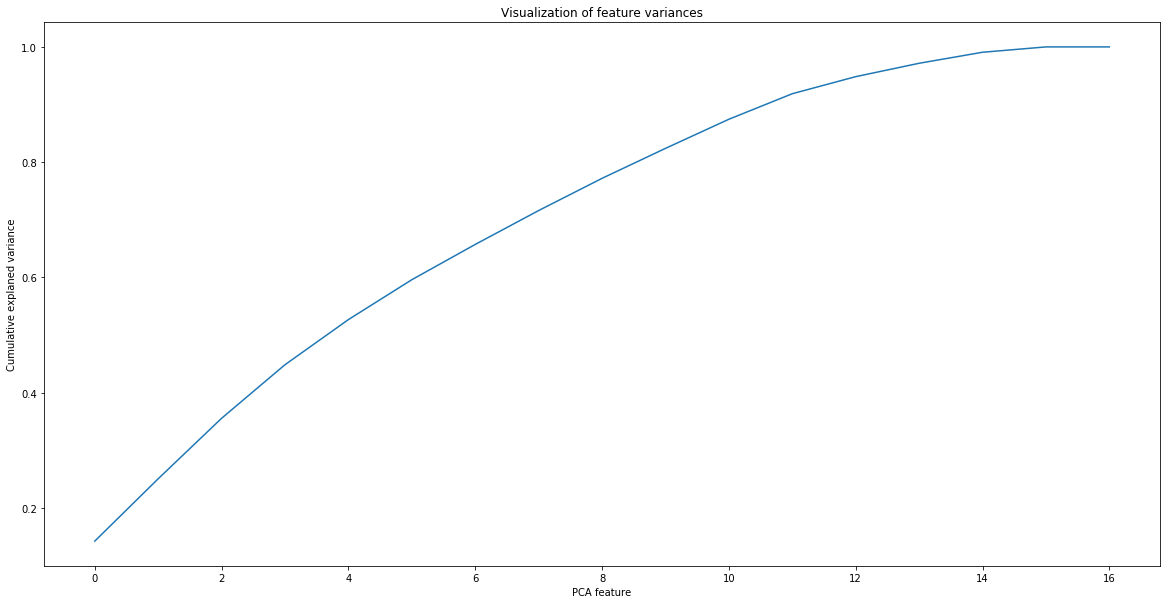

In [18]:
pca = PCA()
pca.fit(scaled_df_linear.drop('Weekly_Sales',axis=1))

#Graphing the data
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Visualization of feature variances')
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explaned variance')
plt.show()

In [19]:
pca_features = pca.fit_transform(scaled_df_linear.drop('Weekly_Sales',axis=1))
pca_features_linear = pd.DataFrame(pca_features)
pca_features_linear['Weekly_Sales'] = df['Weekly_Sales']
pca_features_linear.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\pca_train_linear.csv')
pca_features_linear.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,Weekly_Sales
0,0.314453,-0.910735,-0.763669,0.202073,3.169432,-0.255155,-0.499047,-0.911806,-0.435344,-1.006070,-0.636611,1.502592,0.055922,0.138686,0.223703,-0.413285,-0.000376,87235.57
1,0.573722,-0.922032,-0.659698,0.223087,3.188966,-0.416823,-0.375338,-0.375925,-0.551091,-1.019872,-0.827418,1.553698,-0.298002,-0.005244,0.313156,-0.367669,0.002362,80254.53
2,-0.825579,-0.776800,-0.435613,0.744393,3.187385,-0.197947,-0.554300,-1.171277,-0.358429,-1.001140,-0.495013,1.475658,0.109089,0.135441,0.086524,-0.860347,-0.002932,77715.58
3,-0.509954,-0.779483,-0.365484,-0.270296,3.193785,-0.460613,0.747654,0.903013,-1.272506,-0.788306,0.537209,1.410308,0.139808,0.065518,-0.459940,-0.484269,-0.003191,83599.56
4,-1.300318,-0.661037,0.405473,1.113857,3.168874,-0.324495,-0.375190,-0.414601,-0.555824,-1.014715,-0.741051,1.561930,-0.417805,-0.113519,0.122549,-0.803215,-0.001840,77876.10


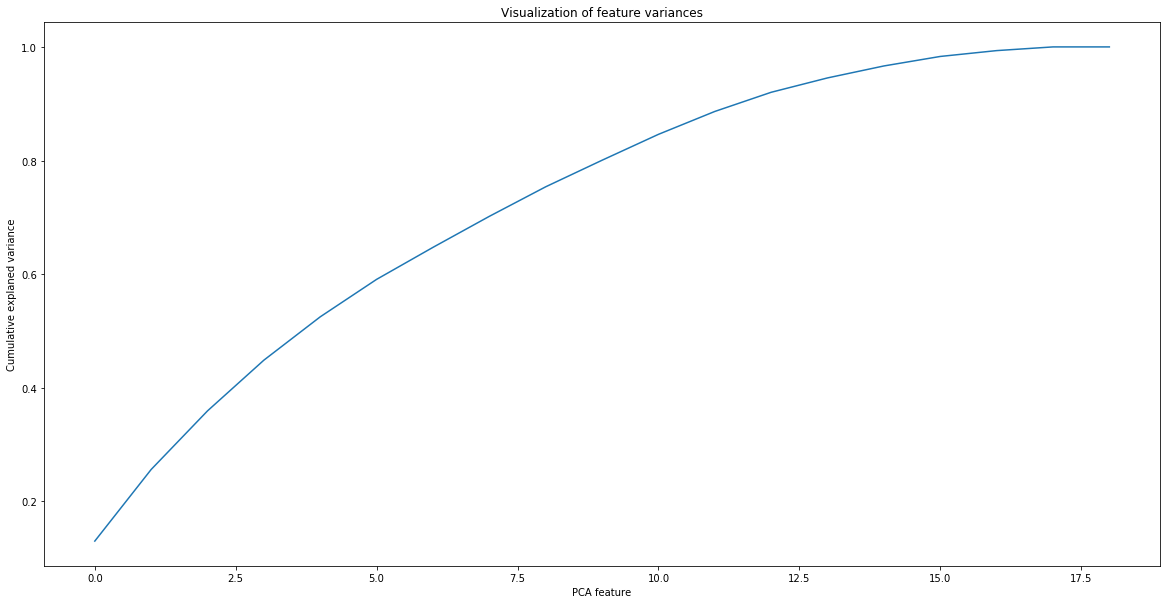

In [20]:
pca.fit(scaled_df.drop('Weekly_Sales',axis=1))

#Graphing the data
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Visualization of feature variances')
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explaned variance')
plt.show()

In [22]:
pca_features = pca.fit_transform(scaled_df.drop('Weekly_Sales',axis=1))
pca_features_all = pd.DataFrame(pca_features)
pca_features_all['Weekly_Sales'] = df['Weekly_Sales']
pca_features_all.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\pca_train_all.csv')
pca_features_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Weekly_Sales
0,0.749024,1.019159,0.168953,-0.678830,2.212308,1.733274,-1.034881,0.035388,0.552644,-1.298549,-0.595630,1.724888,-0.403650,-0.189859,0.197068,0.052015,0.576174,0.410569,-0.000370,87235.57
1,0.627506,1.249321,0.155581,-0.575501,2.224472,1.672642,-0.717711,-0.363284,0.319251,-1.325845,-0.835657,1.768069,-0.357276,-0.538048,0.031313,0.105114,0.622423,0.349045,0.002372,80254.53
2,1.429321,0.103321,0.057536,-0.094313,2.220313,1.771078,-1.278923,0.224174,0.733992,-1.291340,-0.466143,1.712154,-0.604620,-0.221559,0.180249,-0.144270,0.480943,0.797974,-0.002935,77715.58
3,1.199893,0.340415,-0.236703,-0.665774,2.236359,1.656241,0.969407,-0.784410,-0.558264,-1.149784,0.287705,1.706963,-1.093811,-0.228497,0.142438,-0.683232,0.525360,0.352748,-0.003172,83599.56
4,1.739566,-0.242885,-0.382661,0.723381,2.110546,1.750246,-0.836900,-0.293676,0.367265,-1.327163,-0.787508,1.787577,-0.541915,-0.734130,-0.094844,-0.166081,0.547818,0.706165,-0.001835,77876.10


## Model creation:

### Linear Regression

In [4]:
#Loading data
scaled_linear_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\scaled_train_linear.csv',index_col=0)
pca_linear_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\pca_train_linear.csv',index_col=0)
original_linear_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\original_train_linear.csv',index_col=0)

In [23]:
#Splitting
def linear_fit(data):
    X = data.drop(['Weekly_Sales'], axis=1).values
    y_log = data['Weekly_Sales'].values
    results = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)
        linear.fit(X_train,y_train)
        y_pred = linear.predict(X_test)
        results.append(mean_absolute_error(y_test,y_pred))
    return results

[2584.2983044206594, 2574.77205914692, 2578.1109481904364]
[14.60015046487896, 13.914129450637013, 13.393863903659563]


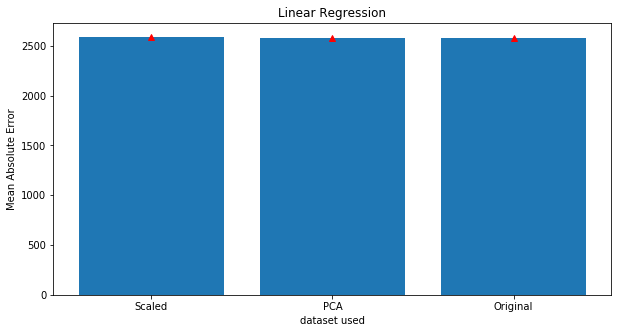

In [27]:
scaled_results = linear_fit(scaled_linear_df)
pca_results = linear_fit(pca_linear_df)
original_results = linear_fit(original_linear_df)

means = [np.mean(scaled_results),np.mean(pca_results),np.mean(original_results)]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Linear Regression")

print(means)
print(stds)

### Ridge

In [5]:
#Loading data
scaled_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\scaled_train.csv',index_col=0)
pca_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\pca_train_all.csv',index_col=0)
original_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\train_all_features.csv',index_col=0)

In [64]:
#Writing a function to find best hyperparams
def optimize_params(model, params, data):
    """Select the best parameters out of a dict for a model given training data"""
    X = data.drop(['Weekly_Sales'], axis=1).values
    y = data['Weekly_Sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)
    reg = model()
    reg_cv = GridSearchCV(reg, param_grid=params, scoring='neg_mean_absolute_error',verbose=10)
    reg_cv.fit(X_train, y_train)
    print(reg_cv.best_params_)

In [48]:
model = Ridge
params_to_test = {'alpha':np.arange(0.0001, 0.001, 0.0001)}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s finished
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.0001}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s finished


{'alpha': 0.0001}


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   11.5s finished


{'alpha': 0.0001}


In [49]:
ridge = Ridge(alpha=0.001)

def ridge_fit(data):
    X = data.drop(['Weekly_Sales'], axis=1).values
    y_log = data['Weekly_Sales'].values
    results = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)
        ridge.fit(X_train,y_train)
        y_pred = ridge.predict(X_test)
        results.append(mean_absolute_error(y_test,y_pred))
    return results

[2587.380676496795, 2581.3281766801483, 2930.056185540217]
[20.376114596513034, 6.914650774572502, 6.6979853493135515]


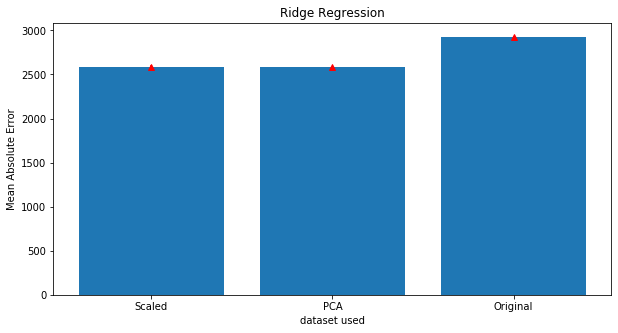

In [50]:
scaled_results = ridge_fit(scaled_df)
pca_results = ridge_fit(pca_df)
original_results = ridge_fit(original_df)

means = [np.mean(scaled_results),np.mean(pca_results),np.mean(original_results)]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Ridge Regression")

print(means)
print(stds)

### Lasso

In [51]:
model = Lasso
params_to_test = {'alpha':np.arange(0.0001, 0.001, 0.0001)}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.1s finished


{'alpha': 0.0001}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.3s finished


{'alpha': 0.0001}


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   16.0s finished


{'alpha': 0.0001}


In [36]:
lasso = Lasso(alpha=0.01)

def lasso_fit(data):
    X = data.drop(['Weekly_Sales'], axis=1).values
    y_log = data['Weekly_Sales'].values
    results = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)
        lasso.fit(X_train,y_train)
        y_pred = lasso.predict(X_test)
        results.append(mean_absolute_error(y_test,y_pred))
    return results

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4435267026746.128, tolerance: 10210154241.2207
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4252597862608.1763, tolerance: 10002679006.167356
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4570729241234.956, tolerance: 10202238009.091928
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

[2581.029836129744, 2586.810763889752, 2932.378926627397]
[17.212600993955952, 12.101138816368078, 10.894237073855988]


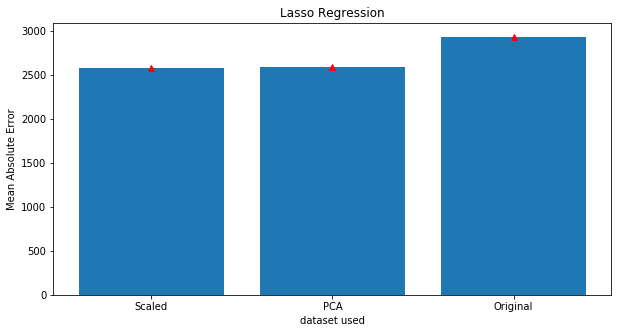

In [37]:
scaled_results = lasso_fit(scaled_df)
pca_results = lasso_fit(pca_linear_df)
original_results = lasso_fit(original_df)

means = [np.mean(scaled_results),np.mean(pca_results),np.mean(original_results)]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Lasso Regression")

print(means)
print(stds)

### RandomForest

In [ ]:
model = RandomForestRegressor
params_to_test = {'n_estimators':np.arange(300, 500, 20)}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=300 ................................................
[CV] ................... n_estimators=300, score=-0.075, total=18.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.3min remaining:    0.0s


[CV] n_estimators=300 ................................................
[CV] ................... n_estimators=300, score=-0.076, total=30.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 49.1min remaining:    0.0s


[CV] n_estimators=300 ................................................
[CV] ................... n_estimators=300, score=-0.075, total=29.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 78.3min remaining:    0.0s


[CV] n_estimators=320 ................................................
[CV] ................... n_estimators=320, score=-0.075, total=15.3min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 93.7min remaining:    0.0s


[CV] n_estimators=320 ................................................
[CV] ................... n_estimators=320, score=-0.076, total= 6.8min
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 100.5min remaining:    0.0s


[CV] ................... n_estimators=320, score=-0.075, total= 6.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 107.1min remaining:    0.0s


[CV] n_estimators=340 ................................................
[CV] ................... n_estimators=340, score=-0.075, total= 6.7min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 113.8min remaining:    0.0s


[CV] n_estimators=340 ................................................
[CV] ................... n_estimators=340, score=-0.076, total= 6.4min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 120.2min remaining:    0.0s


[CV] n_estimators=340 ................................................
[CV] ................... n_estimators=340, score=-0.075, total= 6.5min
[CV] n_estimators=360 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 126.7min remaining:    0.0s


[CV] ................... n_estimators=360, score=-0.075, total= 6.9min
[CV] n_estimators=360 ................................................
[CV] ................... n_estimators=360, score=-0.076, total= 6.8min
[CV] n_estimators=360 ................................................
[CV] ................... n_estimators=360, score=-0.075, total= 7.0min
[CV] n_estimators=380 ................................................
[CV] ................... n_estimators=380, score=-0.075, total= 7.2min
[CV] n_estimators=380 ................................................
[CV] ................... n_estimators=380, score=-0.076, total= 7.2min
[CV] n_estimators=380 ................................................
[CV] ................... n_estimators=380, score=-0.075, total= 7.1min
[CV] n_estimators=400 ................................................
[CV] ................... n_estimators=400, score=-0.075, total= 7.4min
[CV] n_estimators=400 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 688.8min finished


{'n_estimators': 480}


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=300 ................................................
[CV] ................... n_estimators=300, score=-0.120, total=14.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.5min remaining:    0.0s


[CV] n_estimators=300 ................................................
[CV] ................... n_estimators=300, score=-0.120, total=13.9min
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 28.3min remaining:    0.0s


[CV] ................... n_estimators=300, score=-0.120, total=13.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 42.0min remaining:    0.0s


[CV] n_estimators=320 ................................................
[CV] ................... n_estimators=320, score=-0.120, total=14.3min
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 56.3min remaining:    0.0s


[CV] ................... n_estimators=320, score=-0.119, total=14.6min
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 70.9min remaining:    0.0s


[CV] ................... n_estimators=320, score=-0.120, total=14.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 85.3min remaining:    0.0s


[CV] n_estimators=340 ................................................
[CV] ................... n_estimators=340, score=-0.120, total=15.1min
[CV] n_estimators=340 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 100.5min remaining:    0.0s


[CV] ................... n_estimators=340, score=-0.120, total=15.1min
[CV] n_estimators=340 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 115.6min remaining:    0.0s


[CV] ................... n_estimators=340, score=-0.120, total=15.3min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 130.8min remaining:    0.0s


[CV] n_estimators=360 ................................................
[CV] ................... n_estimators=360, score=-0.120, total=16.1min
[CV] n_estimators=360 ................................................
[CV] ................... n_estimators=360, score=-0.120, total=15.8min
[CV] n_estimators=360 ................................................
[CV] ................... n_estimators=360, score=-0.120, total=15.8min
[CV] n_estimators=380 ................................................
[CV] ................... n_estimators=380, score=-0.120, total=16.7min
[CV] n_estimators=380 ................................................


In [99]:
def rf_fit(data):
    X = df.drop(['Weekly_Sales','log_revenue'], axis=1).values
    y_log = df['log_revenue'].values
    results = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        y_pred = np.exp(y_pred) - 4989.94
        y_true = np.exp(y_test)
        results.append(mean_absolute_error(y_true,y_pred))
        
    return results

[13185.510896819824, 13207.0814288867, 13188.42211753047]
[60.9208693297605, 33.5500459931308, 53.67463607277562]


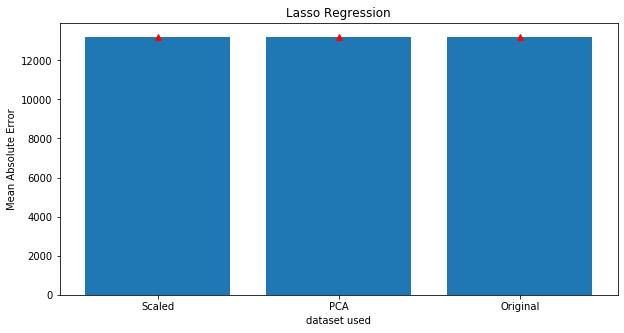

In [100]:
scaled_results = rf_fit(scaled_linear)
pca_results = rf_fit(pca_linear)
original_results = rf_fit(original_linear)

means = [np.mean(scaled_results),np.mean(pca_results),np.mean(original_results)]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("RandomForestRegression")

print(means)
print(stds)